# [프로젝트] 복잡한 자연어 쿼리를 처리하는 Text-to-SQL   

Text-to-SQL 문제는 LLM의 대표적인 활용 분야 중 하나입니다.   
LangChain의 기능을 활용하여, 간단하게 SQL 정보를 전달하고   
 쿼리를 실행, 생성하는 기능을 만들어 보겠습니다.

이번 실습에서는 다음의 DB를 사용합니다.   

easy_sql.db : 도서관 DB  
intermediate_sql.db : 병원 DB   
hard_sql.db : 대학교 DB


In [ ]:
!pip install langgraph langchain langchain_google_genai google_generativeai langchain_community python-dotenv -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.1 MB/s eta 0:00:00


**세션 다시 시작** 해 주세요!

In [ ]:
import zipfile

with zipfile.ZipFile('sql.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

## LangChain의 Utilities 활용하기

SQLite3을 이용해 db에 접근한 뒤, DB 정보를 불러옵니다.

In [ ]:
import sqlite3
from langchain_community.utilities import SQLDatabase


db = SQLDatabase.from_uri("sqlite:///easy_sql.db")


get_table_info()를 통해 스키마를 가져옵니다.    
테이블의 목록 + 3개 Row를 가져오는 작업을 기본으로 수행합니다.

In [ ]:
db_schema = db.get_table_info()
print(db_schema)


CREATE TABLE book_categories (
	book_id INTEGER, 
	category_id INTEGER, 
	PRIMARY KEY (book_id, category_id), 
	FOREIGN KEY(book_id) REFERENCES books (book_id), 
	FOREIGN KEY(category_id) REFERENCES categories (category_id)
)

/*
3 rows from book_categories table:
book_id	category_id
1	2
2	1
3	3
*/


CREATE TABLE book_promotions (
	book_id INTEGER, 
	promotion_id INTEGER, 
	PRIMARY KEY (book_id, promotion_id), 
	FOREIGN KEY(book_id) REFERENCES books (book_id), 
	FOREIGN KEY(promotion_id) REFERENCES promotions (promotion_id)
)

/*
3 rows from book_promotions table:
book_id	promotion_id
1	1
2	1
3	1
*/


CREATE TABLE books (
	book_id INTEGER, 
	title TEXT NOT NULL, 
	author TEXT NOT NULL, 
	price INTEGER NOT NULL, 
	stock INTEGER NOT NULL, 
	PRIMARY KEY (book_id)
)

/*
3 rows from books table:
book_id	title	author	price	stock
1	인공지능의 기초	김영희	25000	10
2	파이썬 프로그래밍	이철수	30000	15
3	데이터 분석 입문	박지민	28000	8
*/


CREATE TABLE categories (
	category_id INTEGER, 
	category_name TEXT NOT NULL, 
	descr

In [ ]:
import os
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI

# 환경 변수 로드
load_dotenv()

os.environ['LANGCHAIN_PROJECT'] = 'LangGraph_FastCampus'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_TRACING_V2']='true'

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

구조화된 출력을 구성합니다.

In [ ]:
from pydantic import BaseModel, Field
import sqlite3

class SQLQuery(BaseModel):
    """SQL 쿼리"""
    explanation: str = Field(description="쿼리의 목적과 기대되는 결과 설명")
    query: str = Field(description="생성된 SQL 쿼리 (반드시 유효한 SQL 문법을 사용)")


In [ ]:
from langchain.prompts import ChatPromptTemplate

structured_llm = llm.with_structured_output(SQLQuery)
prompt = ChatPromptTemplate(["""
당신은 SQL 전문가입니다. 다음 데이터베이스 스키마와 사용자 질의를 분석하여 SQL 쿼리를 작성하세요.

## 데이터베이스 스키마:
{db_schema}

## 사용자 질의:
{query}


테이블을 참고하여, 질문을 쿼리로 변환하세요.
SQLite의 경우 LIMIT clause 를 사용하면 됩니다.
데이터의 결과를 더 잘 전달하기 위해 정렬할 수 있습니다.
주어진 예시 row에 없는 내용이라도, 쿼리를 작성하세요.

정답과 무관한 컬럼에 대한 쿼리를 수행하지 말고, 필요한 내용만 추출하세요.
아래에 주어지는 컬럼 이름과 테이블 정보를 꼭 참고하세요.
존재하지 않는 컬럼에 대한 쿼리를 하지 않도록 주의하세요.
만약 '오늘'과 같이 현재 날짜에 대한 질문이 들어오면 date() 등을 사용하세요.
컬럼 이름은 "로 구분하고, 전체 출력은 마크다운으로 수행하세요.
"""])


sample = {'db_schema':db_schema, 'query':'책이 총 몇 권 있어요?'}

chain = prompt | structured_llm
query = chain.invoke(sample)

query


SQLQuery(explanation='책의 총 권수를 구하는 쿼리', query='SELECT count(*) FROM books')

생성한 쿼리는 run()으로 실행합니다.

In [ ]:
db.run(query.query)

'[(30,)]'

전체 기능을 노드로 연결합니다.

In [ ]:
from typing_extensions import TypedDict

class State(TypedDict):
    db_schema: str
    db_path: str
    query: str
    result: str
    sql_query : str
    final_analysis: str

def generate_query(state: State):
    structured_llm = llm.with_structured_output(SQLQuery)
    prompt = ChatPromptTemplate(["""
    당신은 SQL 전문가입니다. 다음 데이터베이스 스키마와 사용자 질의를 분석하여 SQL 쿼리를 작성하세요.

    ## 데이터베이스 스키마:
    {db_schema}

    ## 사용자 질의:
    {query}


    테이블을 참고하여, 질문을 쿼리로 변환하세요.
    SQLite의 경우 LIMIT clause 를 사용하면 됩니다.
    데이터의 결과를 더 잘 전달하기 위해 정렬할 수 있습니다.
    주어진 예시 row에 없는 내용이라도, 쿼리를 작성하세요.

    정답과 무관한 컬럼에 대한 쿼리를 수행하지 말고, 필요한 내용만 추출하세요.
    아래에 주어지는 컬럼 이름과 테이블 정보를 꼭 참고하세요.
    존재하지 않는 컬럼에 대한 쿼리를 하지 않도록 주의하세요.
    만약 '오늘'과 같이 현재 날짜에 대한 질문이 들어오면 date() 등을 사용하세요.
    컬럼 이름은 "로 구분하고, 전체 출력은 마크다운으로 수행하세요.
    """])
    chain = prompt | structured_llm
    sql_query = chain.invoke(state).query
    state['sql_query'] = sql_query
    return state

def execute_query(state: State):

    sql_query = state['sql_query']
    db_path = state['db_path']
    db = SQLDatabase.from_uri(db_path)

    result = db.run(state['sql_query'])

    state['result'] = result
    return state

def explain_result(state: State):
    prompt = f"""
    당신은 데이터 분석 전문가입니다. SQL 쿼리 결과를 분석하여 사용자가 이해하기 쉽게 설명해주세요.

    ## 원래 질문:
    {state["query"]}

    ## 실행된 SQL 쿼리:
    {state["sql_query"]}

    ## 쿼리 결과:
    {state["result"]}

    ## 작업:
    1. 원래 질문에 직접적으로 답변하세요.
    2. 결과에서 발견된 주요 인사이트를 추출하세요.
    3. 데이터를 종합적으로 분석하고 명확하게 설명하세요.
    4. 결과가 원래 질문의 모든 측면을 다루는지 확인하세요.
    """
    response = llm.invoke(prompt)
    state["final_analysis"] = response.content
    return state

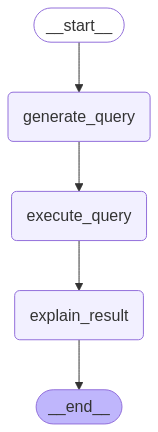

In [ ]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(State)

builder.add_node("generate_query", generate_query)
builder.add_node("execute_query", execute_query)
builder.add_node("explain_result", explain_result)

# 노드 연결
builder.add_edge("generate_query", "execute_query")
builder.add_edge("execute_query", "explain_result")
builder.add_edge("explain_result", END)

# 시작 노드 설정
builder.add_edge(START, "generate_query")

# 그래프 컴파일
graph = builder.compile()
graph


In [ ]:
db_path = "sqlite:///easy_sql.db"
# 데이터베이스 스키마 미리 가져오기
db = SQLDatabase.from_uri(db_path)
db_schema = db.get_table_info()

test_queries=[
    "가장 많은 매출을 올린 작가의 모든 도서 목록과 재고 현황을 조회해주세요.",
    "IT 분야 도서 목록 알려주세요.",
    "리뷰가 좋은 책들 추천해주세요.",
]

for test_query in test_queries:

    initial_state = {
        'query':test_query,
        "db_path": db_path,
        "db_schema": db_schema  # 미리 가져온 스키마 정보 설정
    }
    result = graph.invoke(initial_state)

    print('기존 질문:', test_query)
    print('최종 분석 결과:', result["final_analysis"])

    print('-------------')



기존 질문: 가장 많은 매출을 올린 작가의 모든 도서 목록과 재고 현황을 조회해주세요.
최종 분석 결과: ## 분석 결과 보고서

**1. 질문에 대한 직접적인 답변:**

가장 많은 매출을 올린 작가의 도서 중 하나는 '모바일 앱 프로그래밍'이며, 현재 재고는 18권입니다.

**2. 주요 인사이트:**

*   **최고 매출 작가의 책:** '모바일 앱 프로그래밍'이라는 책이 최고 매출 작가의 책 중 하나로 확인되었습니다. 즉, 해당 작가의 다른 책들도 높은 판매량을 기록할 가능성이 높습니다.
*   **재고 정보:** '모바일 앱 프로그래밍'의 재고가 18권 남아있다는 정보는 추가적인 마케팅이나 프로모션 전략을 수립할 때 중요한 참고 자료가 될 수 있습니다. 예를 들어, 재고 소진을 위해 할인 행사를 진행하거나, 재고가 부족할 경우 추가 생산 계획을 세울 수 있습니다.

**3. 데이터 종합 분석 및 설명:**

본 쿼리는 가장 많은 매출을 올린 작가 한 명의 책 중 하나의 제목과 재고만 반환합니다. 쿼리 자체가 `LIMIT 1`을 사용하여 결과 수를 제한했기 때문입니다.  원래 질문이 "가장 많은 매출을 올린 작가의 *모든* 도서 목록과 재고 현황"을 요구했으므로, 쿼리 결과는 이 요구사항을 완전히 충족하지 못합니다.

**쿼리의 문제점 및 개선 방향:**

현재 쿼리는 작가별 총 매출액을 기준으로 정렬하지만, 가장 높은 매출을 올린 작가의 *모든* 도서 목록을 반환하지 않습니다.  가장 높은 매출을 올린 작가를 먼저 식별하고, 해당 작가의 모든 도서 정보를 가져오는 방식으로 쿼리를 수정해야 합니다.

**수정된 SQL 쿼리 (예시):**

```sql
SELECT b.title, b.stock
FROM books b
WHERE b.author = (SELECT author FROM books b JOIN orders o ON b.book_id = o.book_id GROUP BY b.author ORDER BY SUM(b.price * o.quanti